In [1]:
import os,re,sys,pickle,datetime,time,random,itertools
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from scipy import stats
import math
from tqdm import tqdm
import seaborn as sns
import umap
from multiprocessing import freeze_support
import mordred
from mordred import Calculator, descriptors
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA,NMF
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PolynomialFeatures
import rdkit
from rdkit import Chem
from rdkit.Chem import DataStructs, AllChem, MolFromSmiles, PandasTools, Descriptors, Draw, PropertyMol, rdmolfiles, rdFMCS
from rdkit import RDConfig
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Draw import MolsToGridImage, IPythonConsole, rdMolDraw2D
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions, Font
DrawingOptions.bondLineWidth=1.8
DrawingOptions.includeAtomNumbers=False
size = (150, 150)
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image
randomstate = 42

In [2]:
mols = pd.read_csv('10SELECTED.csv')
mols

,Name,smiles
0,propionate,CCC(=O)[O-]
1,vannilin,COC1=C(C=CC(=C1)C=O)O
2,Acetophenone,O=C(C1=CC=CC=C1)C
3,Coumarin,O1C2=CC=CC=C2C=CC1=O
4,Ethyl_Cinnamate,CCOC(=O)/C=C/C1=CC=CC=C1
5,Folic_acid,C1=CC(=CC=C1C(=O)N[C@@H](CCC(=O)O)C(=O)O)NCC2=...
6,caffeine,CN1C=NC2=C1C(=O)N(C(=O)N2C)C
7,Glycerine,C(C(CO)O)O
8,citric_acid,C(C(=O)O)C(CC(=O)O)(C(=O)O)O
9,Sodium_Lauryl_Sulphate,CCCCCCCCCCCCOS(=O)(=O)[O-].[Na+]


In [4]:
mols['rdmol'] = mols['smiles'].map(lambda x: Chem.MolFromSmiles(x))
mols['inchi'] = mols['rdmol'].map(Chem.MolToInchi)


mols

[07:27:55] WARNING: Proton(s) added/removed

[07:27:55] WARNING: Proton(s) added/removed



,Name,smiles,rdmol,inchi
0,propionate,CCC(=O)[O-],<rdkit.Chem.rdchem.Mol object at 0x00000244314...,"InChI=1S/C3H6O2/c1-2-3(4)5/h2H2,1H3,(H,4,5)/p-1"
1,vannilin,COC1=C(C=CC(=C1)C=O)O,<rdkit.Chem.rdchem.Mol object at 0x00000244314...,InChI=1S/C8H8O3/c1-11-8-4-6(5-9)2-3-7(8)10/h2-...
2,Acetophenone,O=C(C1=CC=CC=C1)C,<rdkit.Chem.rdchem.Mol object at 0x00000244314...,"InChI=1S/C8H8O/c1-7(9)8-5-3-2-4-6-8/h2-6H,1H3"
3,Coumarin,O1C2=CC=CC=C2C=CC1=O,<rdkit.Chem.rdchem.Mol object at 0x00000244314...,InChI=1S/C9H6O2/c10-9-6-5-7-3-1-2-4-8(7)11-9/h...
4,Ethyl_Cinnamate,CCOC(=O)/C=C/C1=CC=CC=C1,<rdkit.Chem.rdchem.Mol object at 0x00000244314...,InChI=1S/C11H12O2/c1-2-13-11(12)9-8-10-6-4-3-5...
5,Folic_acid,C1=CC(=CC=C1C(=O)N[C@@H](CCC(=O)O)C(=O)O)NCC2=...,<rdkit.Chem.rdchem.Mol object at 0x00000244314...,InChI=1S/C19H19N7O6/c20-19-25-15-14(17(30)26-1...
6,caffeine,CN1C=NC2=C1C(=O)N(C(=O)N2C)C,<rdkit.Chem.rdchem.Mol object at 0x00000244314...,InChI=1S/C8H10N4O2/c1-10-4-9-6-5(10)7(13)12(3)...
7,Glycerine,C(C(CO)O)O,<rdkit.Chem.rdchem.Mol object at 0x00000244314...,"InChI=1S/C3H8O3/c4-1-3(6)2-5/h3-6H,1-2H2"
8,citric_acid,C(C(=O)O)C(CC(=O)O)(C(=O)O)O,<rdkit.Chem.rdchem.Mol object at 0x00000244314...,"InChI=1S/C6H8O7/c7-3(8)1-6(13,5(11)12)2-4(9)10..."
9,Sodium_Lauryl_Sulphate,CCCCCCCCCCCCOS(=O)(=O)[O-].[Na+],<rdkit.Chem.rdchem.Mol object at 0x00000244314...,InChI=1S/C12H26O4S.Na/c1-2-3-4-5-6-7-8-9-10-11...


In [5]:
def embed(mol):
    mol_with_H = Chem.AddHs(mol)
    Chem.AllChem.EmbedMolecule(mol_with_H)
    Chem.AllChem.MMFFOptimizeMolecule(mol_with_H)
    return mol_with_H

mols['rdmol_optimized'] = mols.rdmol.map(embed)

mols


,Name,smiles,rdmol,inchi,rdmol_optimized
0,propionate,CCC(=O)[O-],<rdkit.Chem.rdchem.Mol object at 0x00000244314...,"InChI=1S/C3H6O2/c1-2-3(4)5/h2H2,1H3,(H,4,5)/p-1",<rdkit.Chem.rdchem.Mol object at 0x00000244314...
1,vannilin,COC1=C(C=CC(=C1)C=O)O,<rdkit.Chem.rdchem.Mol object at 0x00000244314...,InChI=1S/C8H8O3/c1-11-8-4-6(5-9)2-3-7(8)10/h2-...,<rdkit.Chem.rdchem.Mol object at 0x00000244314...
2,Acetophenone,O=C(C1=CC=CC=C1)C,<rdkit.Chem.rdchem.Mol object at 0x00000244314...,"InChI=1S/C8H8O/c1-7(9)8-5-3-2-4-6-8/h2-6H,1H3",<rdkit.Chem.rdchem.Mol object at 0x00000244314...
3,Coumarin,O1C2=CC=CC=C2C=CC1=O,<rdkit.Chem.rdchem.Mol object at 0x00000244314...,InChI=1S/C9H6O2/c10-9-6-5-7-3-1-2-4-8(7)11-9/h...,<rdkit.Chem.rdchem.Mol object at 0x00000244314...
4,Ethyl_Cinnamate,CCOC(=O)/C=C/C1=CC=CC=C1,<rdkit.Chem.rdchem.Mol object at 0x00000244314...,InChI=1S/C11H12O2/c1-2-13-11(12)9-8-10-6-4-3-5...,<rdkit.Chem.rdchem.Mol object at 0x00000244314...
5,Folic_acid,C1=CC(=CC=C1C(=O)N[C@@H](CCC(=O)O)C(=O)O)NCC2=...,<rdkit.Chem.rdchem.Mol object at 0x00000244314...,InChI=1S/C19H19N7O6/c20-19-25-15-14(17(30)26-1...,<rdkit.Chem.rdchem.Mol object at 0x00000244314...
6,caffeine,CN1C=NC2=C1C(=O)N(C(=O)N2C)C,<rdkit.Chem.rdchem.Mol object at 0x00000244314...,InChI=1S/C8H10N4O2/c1-10-4-9-6-5(10)7(13)12(3)...,<rdkit.Chem.rdchem.Mol object at 0x00000244314...
7,Glycerine,C(C(CO)O)O,<rdkit.Chem.rdchem.Mol object at 0x00000244314...,"InChI=1S/C3H8O3/c4-1-3(6)2-5/h3-6H,1-2H2",<rdkit.Chem.rdchem.Mol object at 0x00000244314...
8,citric_acid,C(C(=O)O)C(CC(=O)O)(C(=O)O)O,<rdkit.Chem.rdchem.Mol object at 0x00000244314...,"InChI=1S/C6H8O7/c7-3(8)1-6(13,5(11)12)2-4(9)10...",<rdkit.Chem.rdchem.Mol object at 0x00000244314...
9,Sodium_Lauryl_Sulphate,CCCCCCCCCCCCOS(=O)(=O)[O-].[Na+],<rdkit.Chem.rdchem.Mol object at 0x00000244314...,InChI=1S/C12H26O4S.Na/c1-2-3-4-5-6-7-8-9-10-11...,<rdkit.Chem.rdchem.Mol object at 0x00000244314...


In [6]:
calc = Calculator(descriptors) # create calculator for all mordred descriptors (can also specify subtype)

df=calc.pandas(mols['rdmol_optimized'])
print(df)

100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


         ABC      ABCGG  nAcid  nBase                             SpAbs_A  \
0   3.047207   3.305183      1      0                            5.226252   
1   7.847124   7.585047      0      0                           13.665822   
2   6.542301   6.236096      0      0                           11.189957   
3   8.554231   7.309128      0      0                           14.426921   
4   9.301778   8.408609      0      0                           16.330127   
5  24.645599  18.074432      2      3                           39.979087   
6  10.870470  10.470730      0      0                           17.668229   
7   3.644924   4.097495      0      0                            6.898979   
8   9.238929   9.624122      3      0                            13.33387   
9  11.790464  10.044030      1      1  multiple fragments (SpAbs_A/SpAbs)   

                              SpMax_A                              SpDiam_A  \
0                            1.847759                              3.6955

In [7]:
#Replace mordred errors with NaNs then drop those descriptors/columns
df=df.applymap(lambda x: np.nan if type(x) in [mordred.error.Missing,mordred.error.Error] else x)
df=df.dropna(axis=1)
print(df.shape)

(10, 1188)


In [8]:
#Dropping columns that have a single value
non_zero_std = df.std() != 0
df = df [non_zero_std[non_zero_std].index]
print(df.shape)

(10, 930)


In [9]:
#Dropping highly correlated descriptors: If a pair of descriptors have a Pearson correlation coefficient (r) value greater than the threshold then one descriptor will be removed.
threshold=0.95
df_corr = df.corr().abs()
upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
df = df.drop(to_drop, axis=1)
print(df.shape)

(10, 274)


In [11]:
#saving the csv list
to_save=pd.concat([mols[['smiles']], df], axis=1)
to_save

,smiles,ABC,nAcid,nBase,nAromAtom,nAtom,nHetero,nH,nC,nN,...,n10FRing,RotRatio,SLogP,JGI2,JGI3,JGI5,JGI6,JGI9,TopoShapeIndex,TSRW10
0,CCC(=O)[O-],3.047207,1,0,0,10,2,5,3,0,...,0,0.250000,-0.8537,0.111111,0.000000,0.000000,0.000000,0.000000,0.500000,27.254130
1,COC1=C(C=CC(=C1)C=O)O,7.847124,0,0,6,19,3,8,8,0,...,0,0.181818,1.2133,0.095238,0.049107,0.047222,0.000000,0.000000,1.000000,40.726374
2,O=C(C1=CC=CC=C1)C,6.542301,0,0,6,17,1,8,8,0,...,0,0.111111,1.8892,0.080808,0.048611,0.062500,0.000000,0.000000,0.666667,37.289972
3,O1C2=CC=CC=C2C=CC1=O,8.554231,0,0,6,17,2,6,9,0,...,1,0.000000,1.7930,0.069444,0.031250,0.020833,0.040000,0.000000,1.000000,41.498380
4,CCOC(=O)/C=C/C1=CC=CC=C1,9.301778,0,0,6,25,2,12,11,0,...,0,0.230769,2.2629,0.059259,0.024038,0.022377,0.010306,0.015625,0.800000,42.596927
5,C1=CC(=CC=C1C(=O)N[C@@H](CCC(=O)O)C(=O)O)NCC2=...,24.645599,2,3,12,51,13,19,19,7,...,1,0.264706,-0.0448,0.080378,0.037760,0.027270,0.013319,0.006518,0.900000,67.689425
6,CN1C=NC2=C1C(=O)N(C(=O)N2C)C,10.870470,0,0,5,24,6,10,8,4,...,0,0.000000,-1.0293,0.115942,0.070000,0.034757,0.000000,0.000000,0.500000,60.521485
7,C(C(CO)O)O,3.644924,0,0,0,14,3,8,3,0,...,0,0.400000,-1.6681,0.133333,0.031250,0.000000,0.000000,0.000000,1.000000,29.753427
8,C(C(=O)O)C(CC(=O)O)(C(=O)O)O,9.238929,3,0,0,21,7,8,6,0,...,0,0.416667,-1.2485,0.117647,0.085938,0.018519,0.000000,0.000000,1.000000,43.565338
9,CCCCCCCCCCCCOS(=O)(=O)[O-].[Na+],11.790464,1,1,0,43,6,25,12,0,...,0,0.750000,0.3881,0.037037,0.026786,0.013889,0.011132,0.007500,0.000000,48.073232


In [12]:
to_save.to_csv('mordred_top101010.csv', index = True)

In [13]:
df.index = df.index.astype(int)
df.dropna(axis=0,inplace=True)
X_all = np.array(df)
X_all_ids = np.array(df.index)
scaler = StandardScaler()
scaler.fit(X_all)
X_all_sc = scaler.transform(X_all)

pca = PCA(n_components=10)     # choose number of PCs

pca.fit(X_all_sc)
X_all_pca    = pca.transform(X_all_sc)
pca_score = pca.explained_variance_ratio_
pca_values = pca.singular_values_
print('Variance explained by individual PCs:',np.around(pca.explained_variance_ratio_, decimals=2),'\n')
print('Total variance explained by PCs:',np.around(np.sum(pca.explained_variance_ratio_), decimals=2))

Variance explained by individual PCs: [0.24 0.2  0.19 0.13 0.08 0.08 0.04 0.03 0.02 0.  ] 

Total variance explained by PCs: 1.0


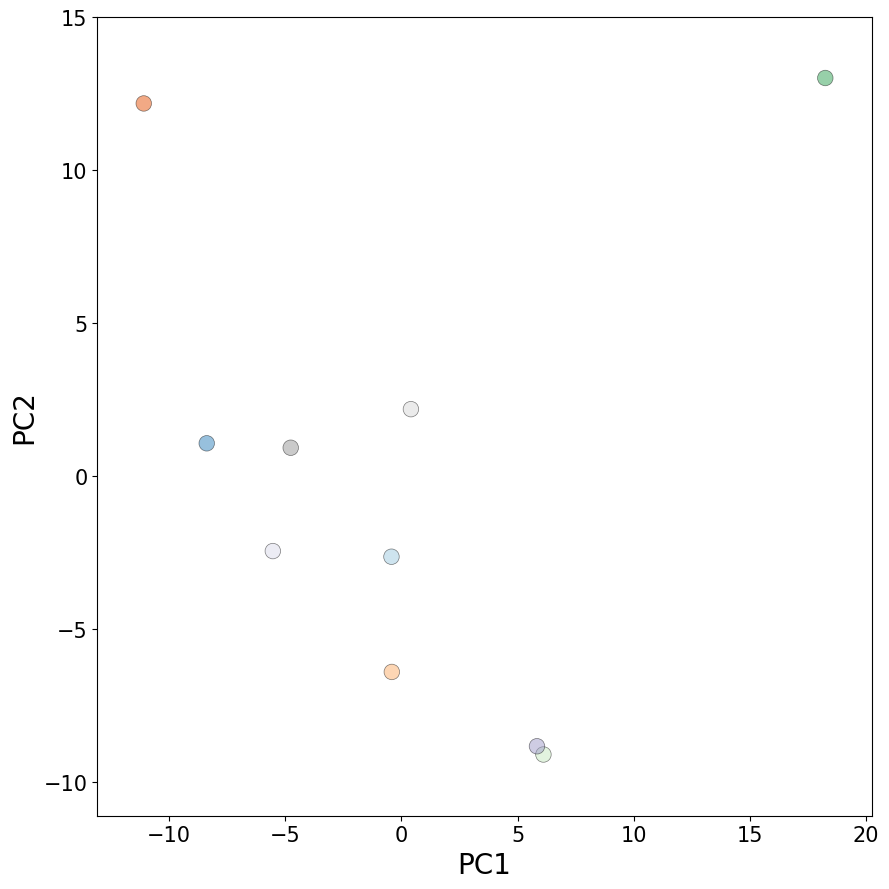

In [19]:
nclusters = 10     # choose number of clusters

####################################################################################

X_use = X_all_pca
X_main_ids = X_all_ids
X_kmeans = X_all_pca
kmeans = KMeans(n_clusters=nclusters, random_state=42).fit(X_kmeans)
dists = []
for x in range(len(X_kmeans)):
    delta = [X_kmeans[x,i]-kmeans.cluster_centers_[kmeans.labels_[x],i] for i in range(len(X_kmeans[0]))]
    dist = np.linalg.norm(delta)
    dists.append(dist)
clusters = {}
clusterdists = {}
clustermins = []
clusterorders_dict = {}
clusterorders = np.zeros(X_kmeans.shape[0])
for x in range(nclusters):
    clusters[x] = [i for i in range(len(kmeans.labels_)) if kmeans.labels_[i] == x]
    clusterdists[x] = [dists[i] for i in clusters[x]]
    clustermins.append(clusters[x][clusterdists[x].index(min(clusterdists[x]))])
    clusterorders_dict[x] = [y for _,y in sorted(zip(clusterdists[x],clusters[x]))]
    for i in clusters[x]:
        clusterorders[i] = clusterorders_dict[x].index(i)+1
f_ind_1 = 0
f_ind_2 = 1
x_min, x_max = X_kmeans[:, f_ind_1].min() - 2, X_kmeans[:, f_ind_1].max() + 2
y_min, y_max = X_kmeans[:, f_ind_2].min() - 2, X_kmeans[:, f_ind_2].max() + 2
plt.figure(figsize=(9,9))
extent = [x_min,x_max,y_min,y_max]
plt.xticks(fontsize=15) 
plt.yticks(fontsize=15)
plt.xlabel(r"PC1",fontsize=20)
plt.ylabel(r"PC2",fontsize=20)
plt.locator_params(axis='y', nbins=8)
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
mapping = kmeans.labels_
cMap = "tab20c"
plt.scatter(X_kmeans[:,f_ind_1], X_kmeans[:,f_ind_2],c=mapping,cmap=cMap,alpha=.5,marker=".",s=500,edgecolor="black",linewidth=0.5)
main_row_id = list(enumerate(X_main_ids))
clusters_with_ids = {}
for i in range(0,len(clusters)):
    emptylist = []
    for j in range(0,len(clusters[i])):
        emptylist.append(main_row_id[clusters[i][j]][1])
    clusters_with_ids[i] = emptylist
    
### plot ligand ids    
#for i in range(0,nclusters):
#    for j in range(0,len(clusters_with_ids[i])):
#        plt.text(X_use[clusters[i][j],f_ind_1],X_use[clusters[i][j],f_ind_2]," "+str(clusters_with_ids[i][j]),color="blue",fontsize=12,ha="left")

### plot centroid labels
#for i in range(0,nclusters):
#    for j in range(0,len(clusters_with_ids[i])):
#        if clusters[i][j] in clustermins:
#            plt.text(X_use[clusters[i][j],f_ind_1],X_use[clusters[i][j],f_ind_2]," "+str(clusters_with_ids[i][j]),color="red",fontsize=13,ha="right")
    
plt.tight_layout()
#plt.savefig("mordred_pca_plot.png",dpi=300)
plt.show()     


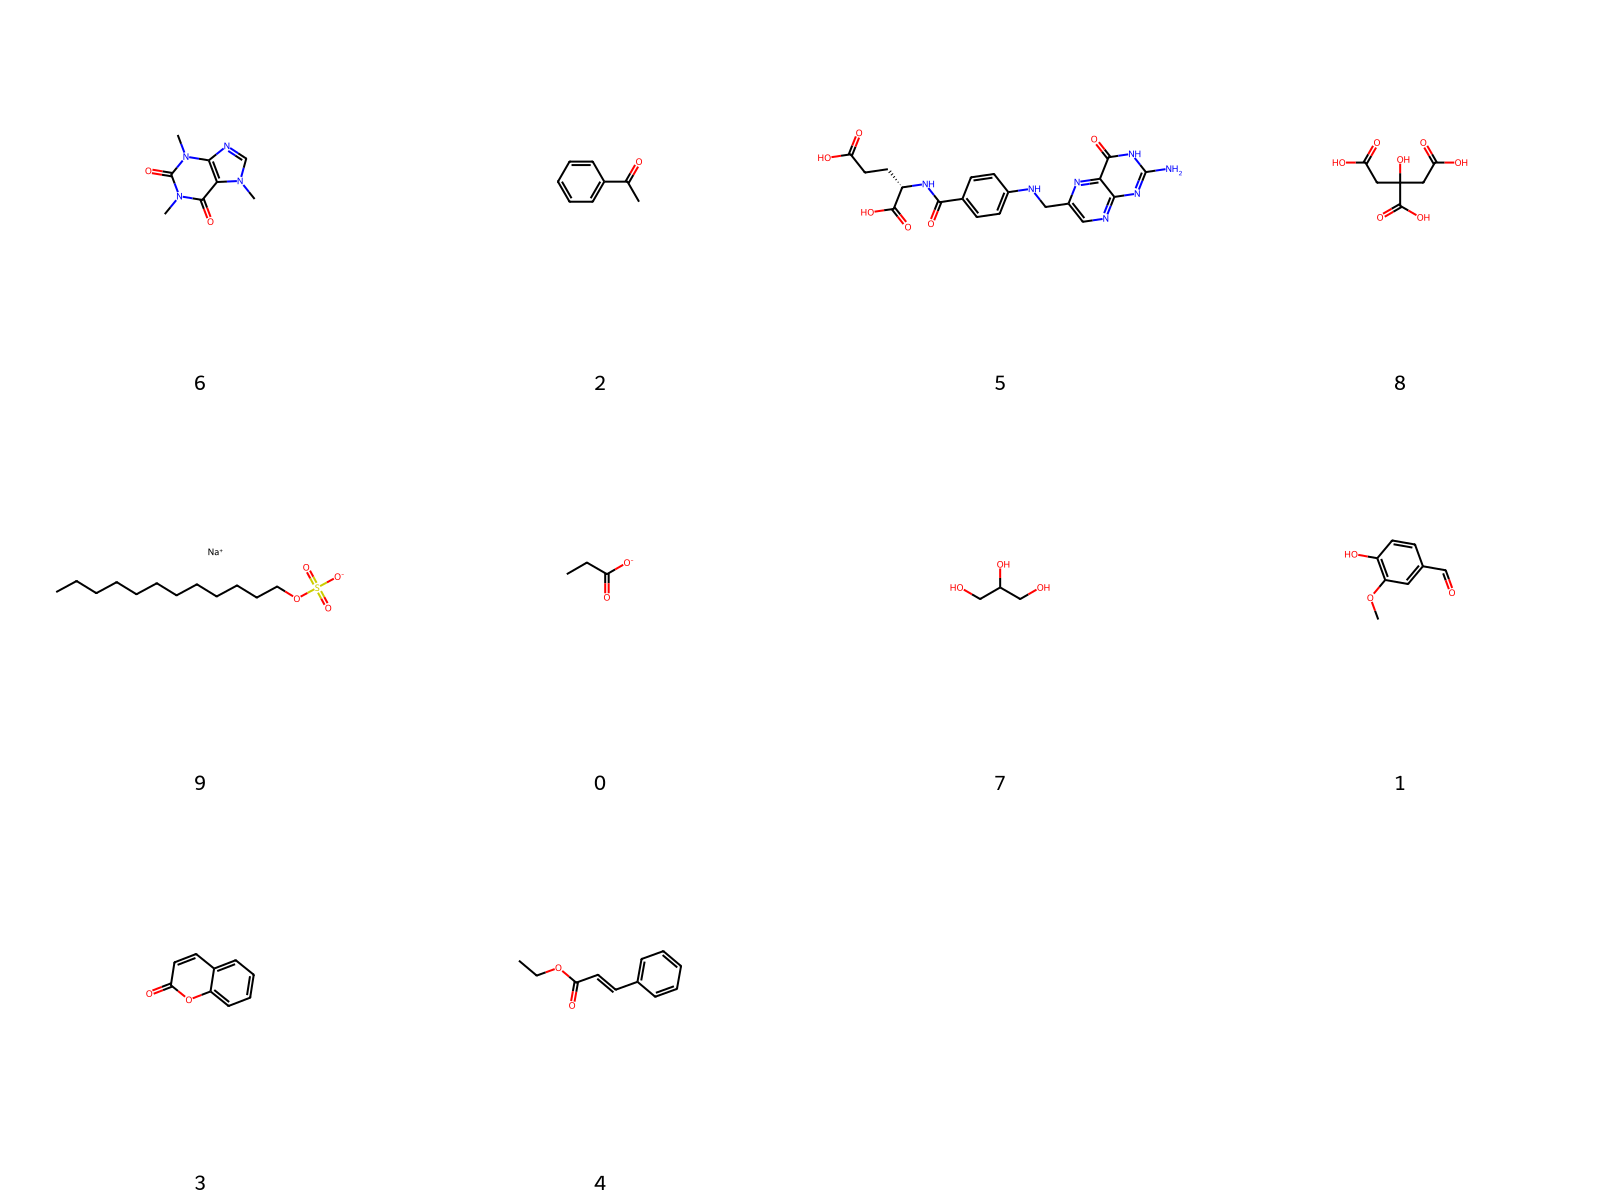

In [20]:
#printing structures closest to the centroids
smiles = list(mols['smiles'])

closest_to_centroids = []
for i in clustermins:
    closest_to_centroids.append(smiles[i])

count=0
subms = []
for i in closest_to_centroids:
    x = Chem.MolFromSmiles(i)
    count+=1
    subms.append(x)
clustermins_str = [str(i) for i in clustermins]
my_labels = clustermins_str  
molsPerRow = 4
subImgSize= (400,400)
nRows = -(count // -molsPerRow)
fullSize = (molsPerRow * subImgSize[0], nRows * subImgSize[1])
img = rdMolDraw2D.MolDraw2DCairo(fullSize[0],fullSize[1],subImgSize[0], subImgSize[1]) # setting up the image
img.drawOptions().legendFontSize=20
img.DrawMolecules(subms[:],legends=my_labels[:])
img.SetFontSize(40)
img.FinishDrawing()

with open('centroids.png','wb+') as wfp:      # opening a png file, goes into current folder
    wfp.write(img.GetDrawingText())           # saving in the image
Image.open('centroids.png')                   # opening it in the notebook